# Homework 2

### Due Date: Thursday, September 27, 2018

### Getting Started

- Training optimal policies / value functions can take very long, so be sure to start solving the problems early to give yourself enough time to finish training everything.
- Please save any plots you generate and add them to the notebook. We will not rerun your code for you.

# Question 1: Modeling Driving Behaviors via Regression

In this problem, we will explore the potential of using neural network models to approximate the acceleration (or car-following) behavior of individual vehicles given certain local observations. Specifically, we will try to estiamte the acceleration $a_\alpha$ of vehicle $\alpha$ using only information on its bumper-to-bumper gaps with the lead vehicle $s_\alpha = x_{\alpha-1} - x_\alpha$, the speed of the ego vehicle $v_\alpha$, and the speed of the lead vehicle $v_{\alpha-1}$. While the majority of this course focuses on sequential decision making tasks, regression problems such as these on deep neural networks may play a significant role in the future of transportation modeling.

<img src="img/micro_data.png" width="600">

### a. NGSIM dataset

[NGSIM](https://ops.fhwa.dot.gov/trafficanalysistools/ngsim.htm) is a collection of datasets providing microscopic data on vehicles on the US 101 and I-80 for a total set of 6 intervals of 15 min, sampled at 0.1/s. It is one of the largest sets of open-source microscopic (per-vehicle) transportation data, and is a good candidate for modeling human driver behavior.

We begin by importing a processed and filtered version of the dataset. In order to do so, go to https://data.transportation.gov/Automobiles/Next-Generation-Simulation-NGSIM-Vehicle-Trajector/8ect-6jqj and export the data as a csv file. You will now have a new csv file called "Next\_Generation\_Simulation\_\_NGSIM\_\_Vehicle\_Trajectories\_and\_Supporting\_Data.csv" containing all the aforementioned data.

Feel free to open and review any of this file. `pandas` is a great tool for visualizing data in Python, and we highly recommend you explore it if you haven't in the past. If you do not have `pandas` installed, enter the following command in your terminal.

    pip install pandas

Once you have installed it, run the below cell to get a clearer visual representation of the data samples.

In [11]:
import tensorflow as tf

In [20]:
import pandas as pd

data = pd.read_csv("~/Documents/fall2018class/EECS290O/EE290O/homeworks/homework2/Next_Generation_Simulation__NGSIM__"
                   "Vehicle_Trajectories_and_Supporting_Data.csv")

data.head()

Vehicle_ID  Frame_ID  Total_Frames    Global_Time  Local_X  Local_Y  \
0           2        13           437  1118846980200   16.467   35.381   
1           2        14           437  1118846980300   16.447   39.381   
2           2        15           437  1118846980400   16.426   43.381   
3           2        16           437  1118846980500   16.405   47.380   
4           2        17           437  1118846980600   16.385   51.381   

      Global_X     Global_Y  v_length  v_Width    ...     D_Zone  Int_ID  \
0  6451137.641  1873344.962      14.5      4.9    ...        NaN     NaN   
1  6451140.329  1873342.000      14.5      4.9    ...        NaN     NaN   
2  6451143.018  1873339.038      14.5      4.9    ...        NaN     NaN   
3  6451145.706  1873336.077      14.5      4.9    ...        NaN     NaN   
4  6451148.395  1873333.115      14.5      4.9    ...        NaN     NaN   

   Section_ID  Direction  Movement  Preceding  Following  Space_Headway  \
0         NaN        NaN       NaN          0          0            0.0   
1         NaN        NaN       NaN          0          0            0.0   
2         NaN        NaN       NaN          0          0            0.0   
3         NaN        NaN       NaN          0          0            0.0   
4         NaN        NaN       NaN          0          0            0.0   

   Time_Headway  Location  
0           0.0    us-101  
1           0.0    us-101  
2           0.0    us-101  
3           0.0    us-101  
4           0.0    us-101  

[5 rows x 25 columns]

### In order to train and validate our model in later sections, we begin by splitting the dataset to test and train sets. Accordingly, in the next cell, perform the following tasks:

1. Filter from the dataset all datapoints that are not from the US-101. This can be done by looking at the "Location" variable.
2. Collect the speed, gap (space headway - lead vehicle length), lead speed, and acceleration (action) for each vehicle at every time step. If a vehicle has no leader or it's headway is zero, remove it from the dataset.
3. Place 80% of them in a train set and 20% in a test set. Justify, in writing, how you chose to split the data.

**Hints**:

- Locating the speeds of the lead vehicles will be computationally demanding if you are doing so by searching a large list. Instead, consider reading the speeds of vehicle from a generated dictionary with keys corresponding to the time and vehicle ID, and/or using a divide and conquer approach where the data is separated by unique time stamps.

In [21]:
import random
us101_data = data.loc[(data['Location'] == 'us-101')]
print(us101_data.shape)

(1048575, 25)


In [22]:
collected = {(car['Vehicle_ID'], car['Global_Time']): 
                    {'speed': car['v_Vel'], 
                     'v_Acc': car['v_Acc'], 
                     'length': car['v_length'], 
                     'lead_v': car['Preceding'],
                     'space_h': car['Space_Headway']}   
             for _, car in us101_data.iterrows()}
print(len(collected))

1048575


In [24]:
# Add in the gap and lead_v velocity for each car in the data using a dictionary.
speed_list = []
gap_list = []
lead_speed_list = []
acc_list = []

for car in collected:
    entry = collected[car]
    timestamp = car[1]
    if entry['lead_v'] and entry['space_h']:
        # Compute the other 2 column data
        lead_veh = (entry['lead_v'], timestamp)
        lead_veh_data = collected[lead_veh]
        speed = entry['speed']
        gap = entry['space_h'] - lead_veh_data['length']
        lead_speed = lead_veh_data['speed']
        
        # Insert the data into respective list
        speed_list.append(speed)
        gap_list.append(gap)
        lead_speed_list.append(lead_speed)
        
        # Insert the acceleration into acc list
        acc_list.append(entry['v_Acc'])

        
input_dict = {
    'speed': speed_list,
    'gap': gap_list,
    'lead_speed': lead_speed_list
}
output_dict = {
    'v_Acc': acc_list
}

print("Done! The number of inputs is %r and the number of outputs is %r" % (len(input_dict), len(output_dict)))


KeyError: (2795, 1118847846400)

In [ ]:
# Make a new data frame with 3 columns: speed, gap (space headway - lead vehicle length), lead speed
input_data = pd.DataFrame(data=input_dict)

# Make a new data frame with just the acceleration
output_data = pd.DataFrame(data=output_dict)

In [ ]:
# 80 % of the data for training your model
train_index = (len(input_data)//100)*80
training_set = input_data[:train_index] 
training_action = output_data[:train_index]
    
# 20 % of the data for validation of your model
test_set = input_data[train_index:]
test_action = output_data[train_index:]

print("Length Training Set: " + str(len(training_set)))
print("Length Training Action: " + str(len(training_action)))
print("Length Test Set: " + str(len(test_set)))
print("Length Test Action: " + str(len(test_action)))

In [ ]:
#save the DATA so as to not have to recreate
training_set.to_csv('training_set.csv')
test_set.to_csv('test_set.csv')

### b. Fully-connected neural networks

In order to estimate an appropriate acceleration model, we will perform regression on a deep fully-connected network using the NGSIM dataset presented in section a. As discussed in lecture 4a, this involves 1) running a **forward pass** through the neural network for a given input, 2) computing the **loss**, 3) **backpropagating** the loss through the neural network to compute the gradients, and finally 4) **updating** the weights and biases.

We begin by implementing the forward pass. In the below method called `forward_pass`, we consider a neural network with *ReLU nonlinearities* applied to the hidden layers and *no nonlinearity* applied to the output layer. Fill in this method to get your forward pass running.

In [11]:
def forward_pass(x, W, b):
    """Performs a forward pass on a deep fully-connected network.

    Parameters
    ----------
        x : np.ndarray
            datapoints from a minibatch of N samples of shape (N,D)
        W : list of np.ndarray
            weight matrices applied to each layer
        b : list of np.ndarray
            bias vectors applied to each layer

    Returns
    -------
        np.ndarray
            output from the neural network with shape (N, A)
        list of list of np.ndarray
            per sample, per layer pre-nonlinearity activation of
            the hidden layers for each sample in the minibatch.
            The first layer should be the input features
    """
    ######################################
    ##### implement your method here #####
    ######################################
    output = (W @ x) + b
    z = []
    
    return output, z

Next, we implement a backwards pass to compute the gradient of the loss with respect to the different hidden and input nodes. This involves computing the derivative of loss with respect to the nodes of the output layers, then incrementally moving through the hidden layers and computing their gradients as well. As you had done for the forward pass, fill in the method for the backwards pass to get it running as well. Assume a mean square error loss:

\begin{equation}
\hat{L}(o,t) = \frac{1}{2N} \big|\big|\ o - t \ \big|\big|^2
\end{equation}

where $o$ is the output from the model, $t$ is the target value, and $N$ is the batch size.

In [ ]:
def backward_pass(output, target, z, W, b):
    """Performs a backwards pass on a deep fully-connected network.

    Parameters
    ----------
        output : np.ndarray
            per sample prediciton of the model with shape (N,A)
        target : np.ndarray
            per sample actual/target values for each sample with 
            shape (N,D)
        z : list of list of np.ndarray
            per sample, per layer pre-nonlinearity activation of
            the hidden layers for each sample in the minibatch.
            The first layer is the input features
        W : list of np.ndarray
            weight matrices applied to each layer
        b : list of np.ndarray
            bias vectors applied to each layer

    Returns
    -------
        list of np.ndarray
            gradients for the weights each hidden layer
        list of np.ndarray
            gradients for the biases each hidden layer
    """
    ######################################
    ##### implement your method here #####
    ######################################
    return dW, db

Finally, we are ready to train the parameters of a neural network to approximate the car-following behavior of people within the NGSIM dataset. In the below cell, perform the following tasks:

1. Initialize the weights of deep neural network of hidden shape [32, 32] with 3 inputs and 1 output, with random uniform numbers between 0 and 1. Also, initialize the biases as all zeros.
2. Using the `forward_pass` and `backward_pass` methods we created earlier in this problem, perform an SGD step to optimize the parameters of your neural network for the loss function described previously in this section. You may use the learning rate and batch size of your choosing. Continue to do so for 200 iterations.
3. Once training is complete, plot the learning curve of your algorithm, i.e. the loss on the test set vs. the SGD step count.

In [28]:
##########################################
################# Step 1 #################
##########################################

##########################################
################# Step 2 #################
##########################################

##########################################
################# Step 3 #################
##########################################

### c. Tensorflow

While implementing regression alorithms in mathematical libraries such as `numpy` is great practice for learning how these algorithms work, in reality practitioners rarely do so and instead rely on machine learning libraries such as `tensorflow`. In the below cell, perform the following tasks:

1. Implement the regression algorithm for the problem posed in this exercise using `tensorflow`. Maintain the same model parameters as those described in section b).
2. Try adding a batch normalization$^1$ or dropout$^2$ layer and compare the training performance of the neural network model wit or without these tricks. What do your results tell you about the chosen modification to the neural network?

**Hint**: some useful tensroflow classes and methods include: `tf.layers.dense`, `tensorflow.contrib.slim.fully_connected`, `tf.nn.relu`, `tf.nn.batch_normalization`, `tf.nn.dropout`

$^1$ Ioffe, Sergey, and Christian Szegedy. "Batch normalization: Accelerating deep network training by reducing internal covariate shift." arXiv preprint arXiv:1502.03167 (2015).

$^2$ Srivastava, Nitish, et al. "Dropout: a simple way to prevent neural networks from overfitting." The Journal of Machine Learning Research 15.1 (2014): 1929-1958.

In [16]:
# Ceate Model
def fully_connected_network(num_inputs, num_layers, num_outputs):
    """Creates a fully-connected neural network computation graph."""
    ##############################################
    ##### construct your neural network here #####
    ##############################################
    # create inputs
    input_ph = tf.placeholder(dtype=tf.float32, shape=[None, num_inputs])
    output_ph = tf.placeholder(dtype=tf.float32, shape=[None, num_outputs])

    hidden_layer = input_ph
    
    for i in range(num_layers):
        hidden_layer = tf.contrib.slim.fully_connected(
            hidden_layer,                                               # input placeholder
            32,                                                    # number of hidden nodes
            weights_initializer=tf.random_uniform_initializer(0,1),  # initializer for the weights
            activation_fn=tf.nn.relu,                               # nonlinearity (None means linear combination)
            scope="hidden_{}".format(i),                                        # name of the node
            reuse=tf.AUTO_REUSE)
    
    # create an output layer
    output_layer = tf.contrib.slim.fully_connected(
        hidden_layer,                                          # input placeholder
        num_outputs,                                            # number of nodes
        weights_initializer=tf.random_uniform_initializer(0,1),  # initializer for the weights
        activation_fn=None,                                     # nonlinearity (None means linear combination)
        scope='output',                                         # name of the node
        reuse=tf.AUTO_REUSE)
    
    return input_ph, output_ph, output_layer

In [19]:
############################################################
########## train your model here using tensorflow ##########
############################################################
import tensorflow as tf

def tf_reset():
    try:
        sess.close()
    except:
        pass
    tf.reset_default_graph()
    return tf.Session()

tf.reset_default_graph()

# Create Model
input_ph, output_ph, output_pred = fully_connected_network(3, 2, 1)

# create a tensorflow session
sess = tf.Session()

# create loss
batch_size = 100
mse = tf.losses.mean_squared_error(output_pred,output_ph)*0.5
                       
# create optimizer
opt = tf.train.AdamOptimizer()
opt = opt.minimize(mse)

# initialize variables
sess.run(tf.global_variables_initializer())

# create saver to save model variables
saver = tf.train.Saver()

# run training
iterations = 20000
for training_step in range(iterations):
    # get a random subset of the training data
    indices = np.random.randint(low=0, high=len(training_set), size=batch_size)
    input_batch = np.array(training_set)[indices]
    output_batch = np.array(training_action)[indices]
    
    print(input_batch)
    
    # run the optimizer and get the mse
    _ = sess.run(opt, feed_dict={input_ph: input_batch, output_ph: output_batch})
    
    # print the mse every so often
    if training_step % 100 == 0:
        mse_run = sess.run(mse, feed_dict={input_ph: input_batch, output_ph: output_batch})

        print('{0:04d} mse: {1:.3f}'.format(training_step, mse_run))
        saver.save(sess, '/tmp/model.ckpt')

NameError: name 'training_set' is not defined

In [73]:
############################################################
###### train your model using a neural network trick #######
############################################################
# Ceate Model
def new_fully_connected_network(num_inputs, num_layers, num_outputs):
    """Creates a fully-connected neural network computation graph."""
    ##############################################
    ##### construct your neural network here #####
    ##############################################
    # create inputs
    input_ph = tf.placeholder(dtype=tf.float32, shape=[None, num_inputs])
    output_ph = tf.placeholder(dtype=tf.float32, shape=[None, num_outputs])

    hidden_layer = input_ph
    
    for i in range(num_layers):
        hidden_layer = tf_slim.fully_connected(
            hidden_layer,                                               # input placeholder
            32,                                                    # number of hidden nodes
            weights_initializer=tf.truncated_normal_initializer(),  # initializer for the weights
            activation_fn=tf.nn.relu,                               # nonlinearity (None means linear combination)
            scope="hidden_{}".format(i),                                        # name of the node
            reuse=tf.AUTO_REUSE)
    
    mean, variance = tf.nn.moments(hidden_layer, axes=0)
    hidden_layer = tf.nn.batch_normalization(
        hidden_layer,
        mean,
        variance,
        offset=0,
        scale=None,
        variance_epsilon=1,
        name=None
    )
    
    # create an output layer
    output_layer = tf_slim.fully_connected(
        hidden_layer,                                          # input placeholder
        num_outputs,                                            # number of nodes
        weights_initializer=tf.truncated_normal_initializer(),  # initializer for the weights
        activation_fn=None,                                     # nonlinearity (None means linear combination)
        scope='output',                                         # name of the node
        reuse=tf.AUTO_REUSE)
    
    return input_ph, output_ph, output_layer

############################################################
########## train your new model here using tensorflow ##########
############################################################
tf.reset_default_graph()

# Create Model
input_ph, output_ph, output_pred = new_fully_connected_network(3, 2, 1)

# create a tensorflow session
sess = tf.Session()

# create loss
batch_size = 100
mse = tf.losses.mean_squared_error(output_pred,output_ph)*0.5                        

# create optimizer
opt = tf.train.AdamOptimizer()
opt = opt.minimize(mse)

# initialize variables
sess.run(tf.global_variables_initializer())

# create saver to save model variables
saver = tf.train.Saver()

# run training
iterations = 20000
for training_step in range(iterations):
    # get a random subset of the training data
    indices = np.random.randint(low=0, high=len(training_set), size=batch_size)
    input_batch = np.array(training_set)[indices]
    output_batch = np.array(training_action)[indices]
    
    # run the optimizer and get the mse
    _ = sess.run(opt, feed_dict={input_ph: input_batch, output_ph: output_batch})
    
    # print the mse every so often
    if training_step % 100 == 0:
        mse_run = sess.run(mse, feed_dict={input_ph: input_batch, output_ph: output_batch})

        print('{0:04d} mse: {1:.3f}'.format(training_step, mse_run))
        saver.save(sess, '/tmp/model.ckpt')

0000 mse: 16.247
0100 mse: 16.254
0200 mse: 8.804
0300 mse: 9.657
0400 mse: 10.065
0500 mse: 10.411
0600 mse: 10.161
0700 mse: 10.917
0800 mse: 9.093
0900 mse: 8.624
1000 mse: 11.199
1100 mse: 10.540


KeyboardInterrupt: 

# Question 2: Traffic Signal Timing with DQN

In this problem, you will implement your first reinforcement learning algorithm: DQN. The algorithm will then be used to control traffic lights in a simple network. Specifically, we consider a single intersection as seen in the figure below, with lanes of length 300 m on either direction and vehicles entering the network from the north-south and east-west directions at a rate of 300 veh/hr and 100 veh/hr, respectively. We choose to study the problem of traffic light signal control using DQN because of the discretizable nature of the action space for the resulting MDP (see the [implementation of the environment](https://github.com/flow-project/flow/blob/master/flow/envs/green_wave_env.py) for more).

<img src="img/dqn_network.png" width="600">

Before we begin optimizing the performance of the traffic light in the given problem, let us first analyze the performance of the baseline form of this problem. Such baselines in Flow can be extracted by simulating the dynamical behavior the network in the absence of any reinforcement learning agent. In this case, we consider a baseline signal schedule where the portion of time when the light is equal for both directions. This control strategy is not optimal, and is symptomatic of one of the primary sources of traffic congestion today.

The below cell instantiates the above described network and computes the average delay of vehicles in the system. Run it once and look at the average return that you get. Note that, while it is not necessary, if you interested in further understanding the inner working of the below lines of code, we recommend you review the following [tutorial on traffic lights](https://github.com/berkeleyflow/flow/blob/master/tutorials/tutorial08_traffic_lights.ipynb) in Flow.

In [18]:
import numpy as np
from flow.envs import PO_TrafficLightGridEnv
from flow.core.experiment import SumoExperiment
from hw2_utils import create_scenario, env_params
from hw2_utils import sumo_params_test as sumo_params

scenario = create_scenario()
env = PO_TrafficLightGridEnv(env_params, sumo_params, scenario)
exp = SumoExperiment(env, scenario)

num_runs = 2
results = exp.run(num_runs, env_params.horizon)
total_return = np.mean(results["returns"])
print("-----------------")
print('The total return across %d runs is %.3f seconds' %(num_runs, total_return))

Round 0, return: 265.9383312068948
Round 1, return: 262.50088011116526
Average, std return: 264.21960565903004, 1.7187255478647785
Average, std speed: 11.880784504834846, 0.0214035455790218
-----------------
The total return across 2 runs is 264.220 seconds


### a. Creating a neural network

We now begin to design the various constituents of our algorithm. The algorithm we will create here, as well as most online RL algorithms in practice, consists of four primary components:

- a **function approximator**, either for the policy or the value/Q function
- a method for **computing actions**,
- a **sample generator**,
- and an **optimization scheme**.

The function approximator is the part of the control strategy that is periodically trained by the RL algorithm. In the case of DQN, the policy denotes the RL agent's estimation of the Q function ($Q : S \to \mathbb{R}^A$), which computes the value of any given action $a_i \in [0, A-1]$ from a starting state $s \in S$.

For this problem, let us consider a simple feed forward network of hidden shape *[100, 50, 25]* with a *ReLU* nonlinearity for the hidden layers, and a weighted sum of with *no nonlinearity* for the output layer. Moreover, let the initial values of all weights in the network to set to truncated normal values with standard a devaition of 1.0, and all biases be initially set to zero. In the below cell, implement this neural network and have the method return the tensorflow Variable corresponding to the output layer. Note that the scope of the output layer should match the one specified in the input parameters.

**Hint**: some useful tensroflow classes and methods include: `tf.layers.dense`, `tensorflow.contrib.slim.fully_connected`, `tf.nn.relu`, `tf.truncated_normal_initializer`, `tf.zeros_initializer`, 

In [74]:
import tensorflow.contrib.slim as tf_slim

def fully_connected_network(inputs, num_actions, scope):
    """Creates a fully-connected neural network computation graph.

    Parameters
    ----------
        inputs : tf.Placeholder
            placeholders for the input features
        num_actions : int
            range of actions that can be performed by the policy. Actions 
            returned must be between 0 to num_actions, inclusive.
        scope : str
            a label that is used to call a specific component in the 
            computation graph

    Returns
    -------
        tf.Variable
            the output player that is responsible for returning the neural
            network estimation. The scope of the output layer should match 
            the one specified in the above parameters.
    """
    ##############################################
    ##### construct your neural network here #####
    ##############################################
    # create a fully connected network layer
    hidden_layer1 = tf_slim.fully_connected(
        inputs,                                               # input placeholder
        100,                                                    # number of hidden nodes
        weights_initializer=tf.truncated_normal_initializer(),  # initializer for the weights
        activation_fn=tf.nn.relu,                               # nonlinearity (None means linear combination)
        scope=scope,                                        # name of the node
        reuse=tf.AUTO_REUSE)
    
    # create a fully connected network layer
    hidden_layer2 = tf_slim.fully_connected(
        hidden_layer1,                                          # input placeholder
        50,                                                     # number of hidden nodes
        weights_initializer=tf.truncated_normal_initializer(),  # initializer for the weights
        activation_fn=tf.nn.relu,                               # nonlinearity (None means linear combination)
        scope=scope+'1',                                        # name of the node
        reuse=tf.AUTO_REUSE)
    
    # create a fully connected network layer
    hidden_layer3 = tf_slim.fully_connected(
        hidden_layer2,                                          # input placeholder
        25,                                                     # number of hidden nodes
        weights_initializer=tf.truncated_normal_initializer(),  # initializer for the weights
        activation_fn=tf.nn.relu,                               # nonlinearity (None means linear combination)
        scope=scope+'2',                                        # name of the node
        reuse=tf.AUTO_REUSE)
    
    # create an output layer
    output_layer = tf_slim.fully_connected(
        hidden_layer3,                                          # input placeholder
        num_actions,                                            # number of nodes
        weights_initializer=tf.truncated_normal_initializer(),  # initializer for the weights
        activation_fn=None,                                     # nonlinearity (None means linear combination)
        scope=scope+'_out',                                         # name of the node
        reuse=tf.AUTO_REUSE)
    
    return output_layer

### b. Computing actions

Next, we impelment our method for computing actions. In DQN, the action taken by the RL agent is chosen to be the action which maximizes the Q value estimated by the policy in section a). Moreover, in order to promote exploration of the task space, the agent performs a random action with probability $\epsilon$, where $\epsilon$ is an exploration rate term that in practice starts high, and is periodically annealed to a smaller value. Mathematically, this is written as:

\begin{equation}
a_t(s_t) = 
\begin{cases}
randint(0, A-1) && \text{if }uniform(0,1) < \epsilon \\
\underset{a}{\arg\max}(Q(s_t,a))  && \text{otherwise}
\end{cases}
\end{equation}

Fill in the below cell to compute and return appropriate actions for the given state.

In [75]:
def compute_action(sess, obs, obs_ph, num_actions, q_func, exploration_rate):
    """Computes an action from the RL policy given an observation.

    With probability exploration_rate, the action is a random integer within 
    the range of the action space.

    Parameters
    ----------
        sess : tf.session
            The tensorflow session
        obs : list
            The observation
        obs_ph : tf.placeholder
            placeholder for the observation
        num_actions : int
            range of actions (the returned action must be an integer between
            0 and num_actions-1, inclusive)
        exploration_rate : float
            Probability of selecting action other than the argmax of the 
            q function

    Returns
    -------
        int
            action to take
    """
    ##################################################
    ##### implement your action computing method #####
    ##################################################
    if exploration_rate > np.random.random():
        action = np.random.randint(0, num_actions-1)
    else:
        # run a session on q_func and get the arg max
        action = np.argmax(sess.run(q_func, feed_dict={obs_ph: obs}))

    return action

### c. Collecting samples from OpenAI gym environments

All RL algorithms require data to train the parameters of their policies. This is generally done by allowing the policy to specify an action $a_t(s_t)$ and then having a simulation environment return an updated state $s_{t+1}$ as well as a reward value associated with the state/action paire $r_t(s_t,a_t)$. In the lectures, we discussed the library "OpenAI gym", which serves to standardize the process of collecting data across multiple RL algorithms. Gym environments do so by relying on two methods for updating the simulation:

- **step**: Advances the simulation by one step. Takes as an input an action from the agent, and returns the next state, the reward, a boolean term to specify whether the rollout completed prematurely, and an additional (optional) info dict.
- **reset**: Returns the environment to some initial state. Unlike the step method, it does not take as an input any action, and only returns the initial state of the environment.

The below method is designed to collect a single rollout worth of simulation data from gym-compatible environments and return the samples as a list of dictionary elements. Fill in the missing elements of this method.

In [76]:
def rollout(env, sess, s_t_ph, q_func, exploration_policy):
    """Executes a single rollout of the environment.

    Parameters
    ----------
        env : gym.Env
            OpenAI gym-compatible environment
        sess : tf.Session
            blank
        s_t_ph : tf.Placeholder
            placeholder for the input states
        q_func : tf.Variable
            output layer to the Q function, which returns expected values
        exploration_policy : object
            an object that provides appropriate exploration rates for the
            action computing procedure

    Returns
    -------
        list of dict
            each element is a new sample, with each dict containing keys 
            for "state", "action", "next_state", "reward", and "done_mask"
    """
    # the samples list will contain information from all new simulation steps
    samples = []
    
    # start a new rollout by resetting the environment and collecting the initial state
    ### FILL IN ###
    curr_state = env.reset()
    

    for i in range(env_params.horizon):
        # compute the action from the compute_action method from part b)
        action = compute_action(sess, [curr_state], s_t_ph, env.action_space.n, q_func, exploration_policy(i)) #  exploration_rate

        # advance the environment once and collect the next state, reward, done, 
        # and info parameters from the environment
        next_s, reward, done, info = env.step(action)

        # add to the samples list a dict containing: "state", "action", "next_state", 
        # "reward", and "done_mask"
        samples.append({"state": curr_state,       ### FILL IN ###
                        "action": action,      ### FILL IN ###
                        "next_state": next_s,  ### FILL IN ###
                        "reward": reward,      ### FILL IN ###
                        "done_mask": done})  ### FILL IN ###
        curr_state = next_s
        # if the environment returns a True for the done parameter, end the rollout 
        # before the time horizon is met
        ### FILL IN ###
        if done:
            break

    return samples

### d. Training

In this section, we implement the core of our RL algorithm: the training operation. For the standard form of DQN, training occurs at the level of the Q function $Q(s,a)$ by optimizing over the loss:

\begin{equation}
\hat{Q}(s_t,a_t) = \big( R(s_t,a_t) + \gamma \cdot \max_a Q_\text{target}(s_{t+1},a) \big) - Q(s_t,a_t)
\end{equation}

where $\gamma$ is a discount rate and $Q_\text{target}$ is the Q target function that is stored separately from the Q value and updated less frequently in order to further stabilize the training procedure.

The below cell is responsible for constructing the tensforflow placeholders and methods that will be called during the optimization scheme. Following the comments placed on each of the empty operations, and referring to the lecture on DQN, fill in the remainder of this cell.

**Hint**: some useful tensroflow classes and methods include: `tf.placeholder`, `tf.one_hot`, `tf.losses.huber_loss`, `tf.train.AdamOptimizer`, `tf.clip_by_norm`, `tf.assign`, `tf.group`, `tf.global_variables_initializer`

In [77]:
def construct_update(env, gamma, learning_rate, norm_clipping):
    """Constructs the necessary tensforflow components needed to execute
    the DQN optimization scheme.

    Parameters
    ----------
        env : gym.Env
            OpenAI gym-compatible environment
        gamma : float
            discount rate
        learning_rate : float
            used during the optimization step
        norm_clipping : float
            saturation point for the gradients

    Returns
    -------
        tf.Variable
            output layer to the Q function
        list of tf.Placeholder
            several placeholders that we create to later feed data through
        tf.Operation
            method for updating the parameters of the Q function
        tf.Operation
            method for transferring the parameters of the Q function to the 
            Q target
        tf.Session
            tensorflow session
    """
    # initialize a tensorflow session
    sess = tf.Session()

    # number of discrete actions the agent can perform
    num_actions = env.action_space.n
    # number of elements in the observation space
    obs_size = env.observation_space.shape[0]

    # actions placeholder (use tf.int32 as the dtype)
    a_t_ph =  tf.placeholder(dtype=tf.int32, shape=[None], name='a_t_ph')   ### FILL IN ###
    # state placeholder (use tf.int32 as the dtype)
    s_t_ph = tf.placeholder(tf.float32, shape=[None, obs_size], name='s_t_ph')  ### FILL IN ###
    # next state placeholder (use tf.int32 as the dtype)
    s_tp1_ph = tf.placeholder(tf.float32, shape=[None, obs_size], name='s_tp1_ph')  ### FILL IN ###
    # reward placeholder (use tf.int32 as the dtype)
    rew_ph = tf.placeholder(tf.float32, shape=[None], name='rew_ph')  ### FILL IN ###
    # done placeholder (use tf.int32 as the dtype)
    done_ph = tf.placeholder(tf.float32, shape=[None], name='done_ph')  ### FILL IN ###

    # construct your q functions using the method from part a) and give it the scope "q_func"
    q = fully_connected_network(s_t_ph, num_actions, 'q_func') ### FILL IN ###

    # get the weights of your q function
    q_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                                 scope=tf.get_variable_scope().name + "q_func")

    # construct the q target using the method from part a) and give it the scope "q_target"
    q_target = fully_connected_network(s_tp1_ph, num_actions, 'q_target') ### FILL IN ###

    # get the weights of your q function
    q_target_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                                        scope=tf.get_variable_scope().name + "q_target")

    # perform the update step here. Be sure to use "gamma" and "learning_rate"
    # as specified by the input parameters, and clip the gradients by the 
    # "norm_clipping" term
    ### FILL IN ###
    
    q_value = rew_ph + (1-done_ph)*gamma*tf.reduce_max(q_target, axis=1)
    q_pred = tf.reduce_max(q*tf.one_hot(a_t_ph, num_actions), axis=1)
    loss = tf.losses.huber_loss(q_value, q_pred)
    
    opt = tf.train.AdamOptimizer(learning_rate=learning_rate)
    grad_var_list = opt.compute_gradients(loss, var_list=q_params)  # Gives a list of (grad, variable) pairs where the gradient is computed for that associated variable
    grad, variables = zip(*grad_var_list)          # Separates the gradients and variables in their own lists 
    grad, _ = tf.clip_by_global_norm(grad, norm_clipping)
    update = opt.apply_gradients(zip(grad, variables))

    # create an assignment operator q_target_params to copy the q function params
    # to the q_target params. "update_target_expr" will be called periodically to 
    # copy Q network to target Q network. You will want to use the variables q_params
    # and q_target_params
    ### FILL IN ###
    
    update_target_expr = []
    
    sort_q_params = sorted(q_params, key=lambda v: v.name)
    sort_target_params = sorted(q_target_params, key=lambda v: v.name)
    
    for i in range (len(sort_q_params)):
        update_target_expr.append(tf.assign(sort_target_params[i], sort_q_params[i]))
    update_target_expr  = tf.group(*update_target_expr)

    # initialize all the variables
    ### FILL IN ###
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    
    ph_list = s_t_ph, s_tp1_ph, a_t_ph, rew_ph, done_ph
    return q, ph_list, update, update_target_expr, sess

The next method is responsible for executing the entire training session. In this method, the replay buffer is periodically updated with data from the rollouts in part c) and a series of update steps are performed after every rollout. Note that this is somewhat different from the regular DQN approach, where the Q functions are trained after a number of steps instead of rollouts. Finally, after a number of rollouts, the parameters of the target Q function are modified to match those of the actual Q function.

With the above description in mind, fill in the below cell to complete your DQN algorithm.

In [78]:
import os
from queue import *

def train(env,
          num_iterations=20,
          steps_per_iteration=10000,
          num_opt_steps=10,
          batch_size=1000,
          learning_rate=1e-4,
          buffer_size=50000,
          initial_explore_rate=1.0,
          final_explore_rate=0.02,
          anneal_rate=int(1e5),
          norm_clipping=10, 
          gamma=0.5):
    """Runs an entire training session of DQN on an environment.

    Note that the hyper-parameters are inputs to this method in order to 
    facilitate hyper-parameter tuning.

    Parameters
    ----------
        env : gym.Env
            OpenAI gym-compatible environment
        num_iterations : int
            number of training iterations before training stops
        steps_per_iteration : int
            number of steps to perform before the parameters of the 
            Q target are updated
        num_opt_steps : int
            number of optimization steps to take after every rollout
        learning_rate : float
            used by the optimizer
        buffer_size : int
            maximum number of elements the replay buffer can hold
        initial_explore_rate : float
            used by the exploration strategy
        final_explore_rate : float
            used by the exploration strategy
        anneal_rate : int
            used by the exploration strategy
        batch_size : int
            number of samples used to compute the gradient
        norm_clipping : float
            saturation point for the gradients
        gamma : float
            discount rate

    Returns
    -------
        list of float
            a list of average returns per ten rollouts
    """
    # define the replay buffer
    replay_buffer = []### FILL IN ###

    # define the exploration policy (the y term corresponds to the number of previous steps)
    exploration_policy_offset = lambda x,y: max(initial_explore_rate - 1/anneal_rate * (x+y), final_explore_rate)

    # collect the necessary tensorflow-specific components
    q_func, ph_list, update, update_target_expr, sess = construct_update(env, gamma, learning_rate, norm_clipping)
    s_t_ph, s_tp1_ph, a_t_ph, rew_ph, done_ph = ph_list

    # to store cumulative returns per rollout
    cumulative_return_per_rollout = []
    cumulative_return_per_ten_rollouts = []

    # create saver to save model variables
    saver = tf.train.Saver()
    
    # variables used during saving the checkpoint
    current_dir = os.getcwd()
    max_cumulative_ret = -float("inf")

    total_steps = 0
    num_rollouts = 0
    for i in range(num_iterations):
        while total_steps < steps_per_iteration * (i+1):
            # update the policy with the number of previous timesteps
            exploration_policy = lambda x: exploration_policy_offset(x, total_steps)

            # perform one rollout of the policy on the environment and collect the samples
            samples = rollout(env, sess, s_t_ph, q_func, exploration_policy)
            total_steps += len(samples)
            num_rollouts += 1

            # update the cumulative rewards terms (so that we may visualize the 
            # improvements later)
            cumulative_return_per_rollout.append(sum(sample["reward"] for sample in samples))

            # store cumulative returns in means of 10 rollouts
            if num_rollouts % 10 == 0:
                cumulative_return_per_ten_rollouts.append(
                    np.mean(cumulative_return_per_rollout))

            for sample in samples:
                # add to the replay buffer a dict containing: "states", "next_states", 
                # "actions", "rewards", and "done_masks". Note that the number of elements 
                # should should match the input parameter **buffer_size**.
                ### FILL IN ###
                replay_buffer.append(sample)
                if len(replay_buffer) > buffer_size:
                    replay_buffer = replay_buffer[1:]

            # perform actual training here
            for _ in range(num_opt_steps):
                # collect a subset of samples from the replay buffer with length 
                # **batch_size**
                ### FILL IN ###
                
                sample_ind = np.random.randint(0, len(replay_buffer), size=batch_size)
                batch = np.array(replay_buffer)[sample_ind]

                # perform the update process by calling the update method and feeding 
                # the samples to their corresponding placeholders
                feed_dict = {
                    s_t_ph: np.array([sample['state'] for sample in batch]),
                    s_tp1_ph: np.array([sample['next_state'] for sample in batch]),
                    a_t_ph: np.array([sample['action'] for sample in batch]),
                    rew_ph:  np.array([sample['reward'] for sample in batch]),
                    done_ph: np.array([sample['done_mask'] for sample in batch])
                }
                sess.run([update], feed_dict=feed_dict)  ### FILL IN ###

        # update the parameters of the target q function to match those of the actual
        # q function
        sess.run(update_target_expr)  ### FILL IN ###

        
        # used to monitor progress
        print('------------------')
        print('|the total reward of 10 rollouts was:', np.mean(cumulative_return_per_rollout[-10:]))
        print('|the exploration fraction is:', exploration_policy(total_steps))
        print('|number of episodes so far:', len(cumulative_return_per_rollout))
        print('|steps so far:', total_steps)
        print('------------------\n')


    saver.save(sess, os.path.join(current_dir, "model.ckpt"))
    return cumulative_return_per_ten_rollouts, saver

You can test your implementation of DQN on the "CartPole-v0" environment below.

In [ ]:
import tensorflow as tf
import gym

tf.reset_default_graph()
env = gym.make("CartPole-v0")
avg_reward_per_iteration, saver = train(env, learning_rate=5e-6)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
------------------
|the total reward of 10 rollouts was: 9.6
|the exploration fraction is: 0.79992
|number of episodes so far: 1030
|steps so far: 10004
------------------

------------------
|the total reward of 10 rollouts was: 12.2
|the exploration fraction is: 0.59966
|number of episodes so far: 1925
|steps so far: 20017
------------------

------------------
|the total reward of 10 rollouts was: 16.8
|the exploration fraction is: 0.39974
|number of episodes so far: 2644
|steps so far: 30013
------------------

------------------
|the total reward of 10 rollouts was: 18.0
|the exploration fraction is: 0.1999399999999999
|number of episodes so far: 3216
|steps so far: 40003
------------------

------------------
|the total reward of 10 rollouts was: 29.1
|the exploration fraction is: 0.02
|number of episodes so far: 3637
|steps so far: 50014
------------------

------------------
|the 

We are now finally ready to train your traffic signal schedule. The below cell executes one complete instance of training. Run this cell, and in the cell immediately below it, plot the average return per iteration. **Note**: If all went well, it is still possible that your algorithm's raining curve is still very noisy; for this reason, we will in the final problem look to augmentations of DQN, namely double q-learning.

In [9]:
import tensorflow as tf
import gym
from gym.envs.registration import register
from hw2_utils import create_scenario, env_params
from hw2_utils import sumo_params_train as sumo_params

tf.reset_default_graph()
scenario = create_scenario()

# register the Flow gym environment with OpenAI gym
env_name = "PO_TrafficLightGridEnv"
try:
    register(
        id=env_name + "-v0",
        entry_point='flow.envs:' + env_name,
        max_episode_steps=env_params.horizon,
        kwargs={
            "env_params": env_params,
            "sumo_params": sumo_params,
            "scenario": scenario
        }
    )
except:  # this will happen if you already registered the environment
    pass
env = gym.envs.make(env_name + "-v0")

# perform the training iterations for set duration
avg_reward_per_iteration, saver = train(env)


------------------
|the total reward of 10 rollouts was: -315.5034938001936
|the exploration fraction is: 0.8
|number of episodes so far: 5
|steps so far: 10000
------------------

------------------
|the total reward of 10 rollouts was: nan
|the exploration fraction is: 0.6
|number of episodes so far: 0
|steps so far: 20000
------------------



/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


------------------
|the total reward of 10 rollouts was: -357.4853788671327
|the exploration fraction is: 0.3999999999999999
|number of episodes so far: 5
|steps so far: 30000
------------------

------------------
|the total reward of 10 rollouts was: nan
|the exploration fraction is: 0.19999999999999996
|number of episodes so far: 0
|steps so far: 40000
------------------



/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


------------------
|the total reward of 10 rollouts was: -328.71483122605935
|the exploration fraction is: 0.02
|number of episodes so far: 5
|steps so far: 50000
------------------



KeyboardInterrupt: 

NameError: name 'avg_reward_per_iteration' is not defined

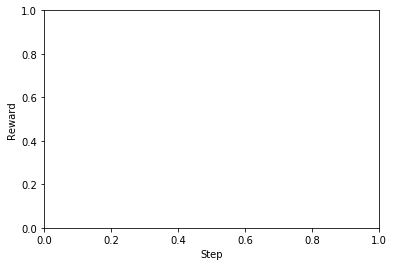

In [10]:
######################################
###### plot learning curve here ######
######################################

import matplotlib.pyplot as plt
plt.xlabel('Step')
plt.ylabel('Reward')
plt.plot(np.linspace(0,2000000,50), avg_reward_per_iteration)

### e. Visualizing Learned Control Strategies

Let us now try to visualize the performance of the policy in simulation. In the below cell, we once again run the simulation as we had at the start, expect with the addition of an *rl_actions* method. This method allows us to dictate the actions of RL agents outside of the training loop. Fill in the *rl_actions* method with your new trained policy, and run the cell to visualize your traffic light policy in action. Assuming your algorithm ran as expected, the average delay you receive from the trained policy should be less than the value you received at the start of this the problem before training, meaning that your algorithm has improved traffic flow!

In [11]:

import numpy as np
from flow.envs import PO_TrafficLightGridEnv
from flow.core.experiment import SumoExperiment
from hw2_utils import create_scenario, env_params
from hw2_utils import sumo_params_test as sumo_params

scenario = create_scenario()
env = PO_TrafficLightGridEnv(env_params, sumo_params, scenario)
q_func, ph_list, update, update_target_expr, sess = construct_update(env, gamma, learning_rate, norm_clipping)
s_t_ph, s_tp1_ph, a_t_ph, rew_ph, done_ph = ph_list

def rl_actions(state):
    ###########################################################
    ###### return the action from the trained Q function ######
    ###########################################################
    saver.restore(sess, 'model.ckpt')
    action = np.argmax(sess.run(q_func, feed_dict={obs_ph: state}))
    
    return action


exp = SumoExperiment(env, scenario)

# run 10 rollouts of the environment with the RL actions being specified by
# your trained policy
results = exp.run(10, env_params.horizon, rl_actions=rl_actions)

# compute and print the new total delay
total_delay = np.mean(results["returns"])
print("-----------------")
print('The new total return is %.3f seconds' %(total_delay))

**********************************************************
**********************************************************
**********************************************************
significantly decrease after large number of rollouts. In 
order to avoid this, set SumoParams(restart_instance=True).
**********************************************************
**********************************************************
**********************************************************


NameError: name 'saver' is not defined

### f. (BONUS) Double Q Learning

Several variants of DQN have arisen over the years as a means of potentially improving training performance. Once such modification is the double Q learning procedure, where the Q functions used to perform action selection and value estimation are separated in order to prevent the Q algorithm from prioritizing optimistically evaluated actions.

In the below cell, extract the method from the previous parts that needs to be updated to implement double Q learning and modify the necessary lines of code. **Hint**: you only need to modify one method.

In [ ]:
##############################################
###### implement double Q learning here ######
##############################################

Once you have implemented the double Q learning modification, test the performance of the new algorithm on the training procedure by plotting the the average and std of the training for both methods across 3 training sessions. Use default hyperparameters for all training instances. You may refer to the supplementary cell below for plotting average/range training curves, or use your own.

In [ ]:
##############################################################
###### train both variants and plot the training curves ######
##############################################################

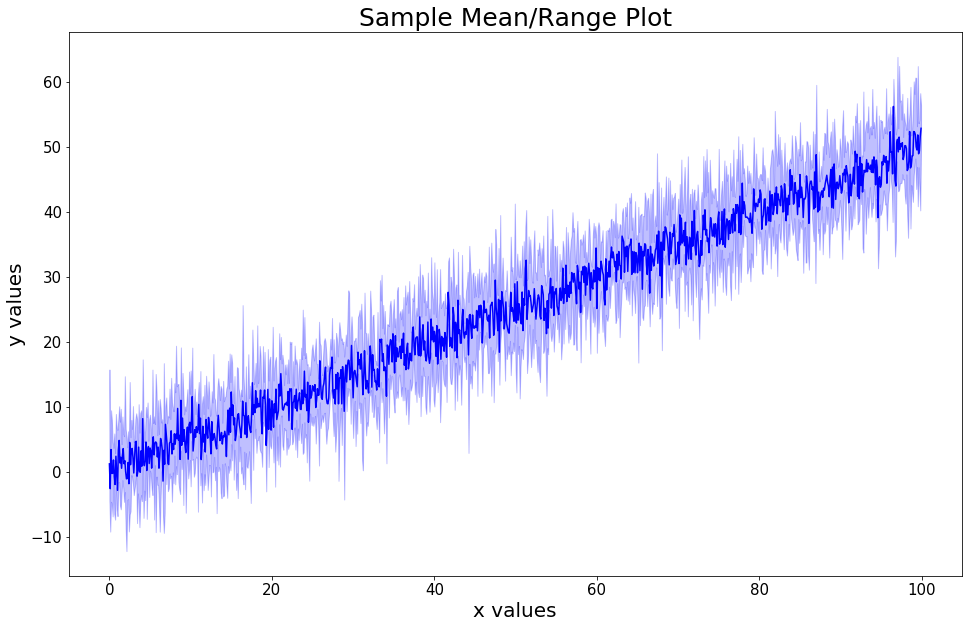

In [42]:
###### Sample Plotting Method ######

import matplotlib.pyplot as plt
import numpy as np

# collect 5 noisy samples of some function (in this case y = 0.5x)
x = np.arange(0, 100, 0.1)
y = [0.5 * x + np.random.normal(0, 5, len(x)) for _ in range(5)]

# Actual plotting past here

plt.figure(figsize=(16,10))
# add line for mean of y values
plt.plot(x, np.mean(y, 0), color="b")
# fill in between min and max with lighter color
plt.fill_between(x, np.min(y, 0), np.max(y, 0), alpha=0.25, color='b')
plt.title("Sample Mean/Range Plot", fontsize=25)
plt.ylabel('y values', fontsize=20)
plt.xlabel('x values', fontsize=20)
plt.tick_params(labelsize=15)
plt.show()